In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import StandardScaler


### Read Test+train Datasets

In [5]:
X_train_path = 'X_train.csv'
y_train_path = 'y_train.csv'
X_test_path = 'X_test.csv'

# Read the csv files
X_train = pd.read_csv(X_train_path, index_col=0)
y_train = pd.read_csv(y_train_path, index_col=0)
X_test = pd.read_csv(X_test_path, index_col=0)

# Remove redundant id column
X_train.drop(columns=['id'], inplace=True)
X_test.drop(columns=['id'], inplace=True)


In [6]:
from typing import Literal
from sklearn.base import BaseEstimator
from sklearn.compose import make_column_transformer

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.map(self.mapping)

def drop_bad_columns(X: pd.DataFrame):
    return X.dropna().copy()

class DropDuplicates(BaseEstimator, TransformerMixin):
    def __init__(self, subset):
        self.subset = subset
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop_duplicates(subset=self.subset)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]


In [7]:
rnd_state = 10

# Define the pipeline
num_attrs = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']
cat_attrs = ['Education', 'City', 'Gender', 'EverBenched', 'Race']
education_order = ["Bachelors", "Masters", "PHD"]

# Adding a scaler to the pipeline
ct = ColumnTransformer([
        ('TargetEncoder', TargetEncoder(), ['City', 'Race']),
        ('EducationLevelEncoder', OrdinalEncoder(categories=[education_order]), ['Education']),
        ('imputer', SimpleImputer(strategy="median"), num_attrs),
        ('dummy', FunctionTransformer(pd.get_dummies, kw_args={'drop_first': True, "dtype": int}), ['EverBenched', 'Gender'])
    ], remainder='passthrough', verbose_feature_names_out=False)
ct.set_output(transform='pandas')

scaler_transformer = make_column_transformer((StandardScaler(), num_attrs), remainder='passthrough', verbose_feature_names_out=False)
scaler_transformer.set_output(transform='pandas')

full_pipeline = Pipeline([
    ('ColumnTransformers', ct),
    ('scaler', scaler_transformer),
])

# # Fit and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train, y_train)
# X_train_prepared.head()


c:\Python\Python10\lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(
c:\Python\Python10\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
full_train_ds = X_train_prepared.join(y_train)
full_train_ds.head()


,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,City,Race,Education,EverBenched_Yes,Gender_Male,LeaveOrNot
1847,0.495792,0.543609,-0.808306,0.705485,0.272900,0.350161,0.0,1,1,0
2905,-1.649326,0.543609,-0.602511,0.705485,0.272900,0.350161,0.0,0,1,0
4610,-0.040488,0.543609,-1.014101,-0.574776,0.513925,0.347687,0.0,0,0,1
2228,-1.649326,0.543609,-0.396716,-1.214907,0.274888,0.357134,0.0,0,1,0
5,0.495792,0.543609,-1.425690,-1.855038,0.274888,0.348667,0.0,0,1,0


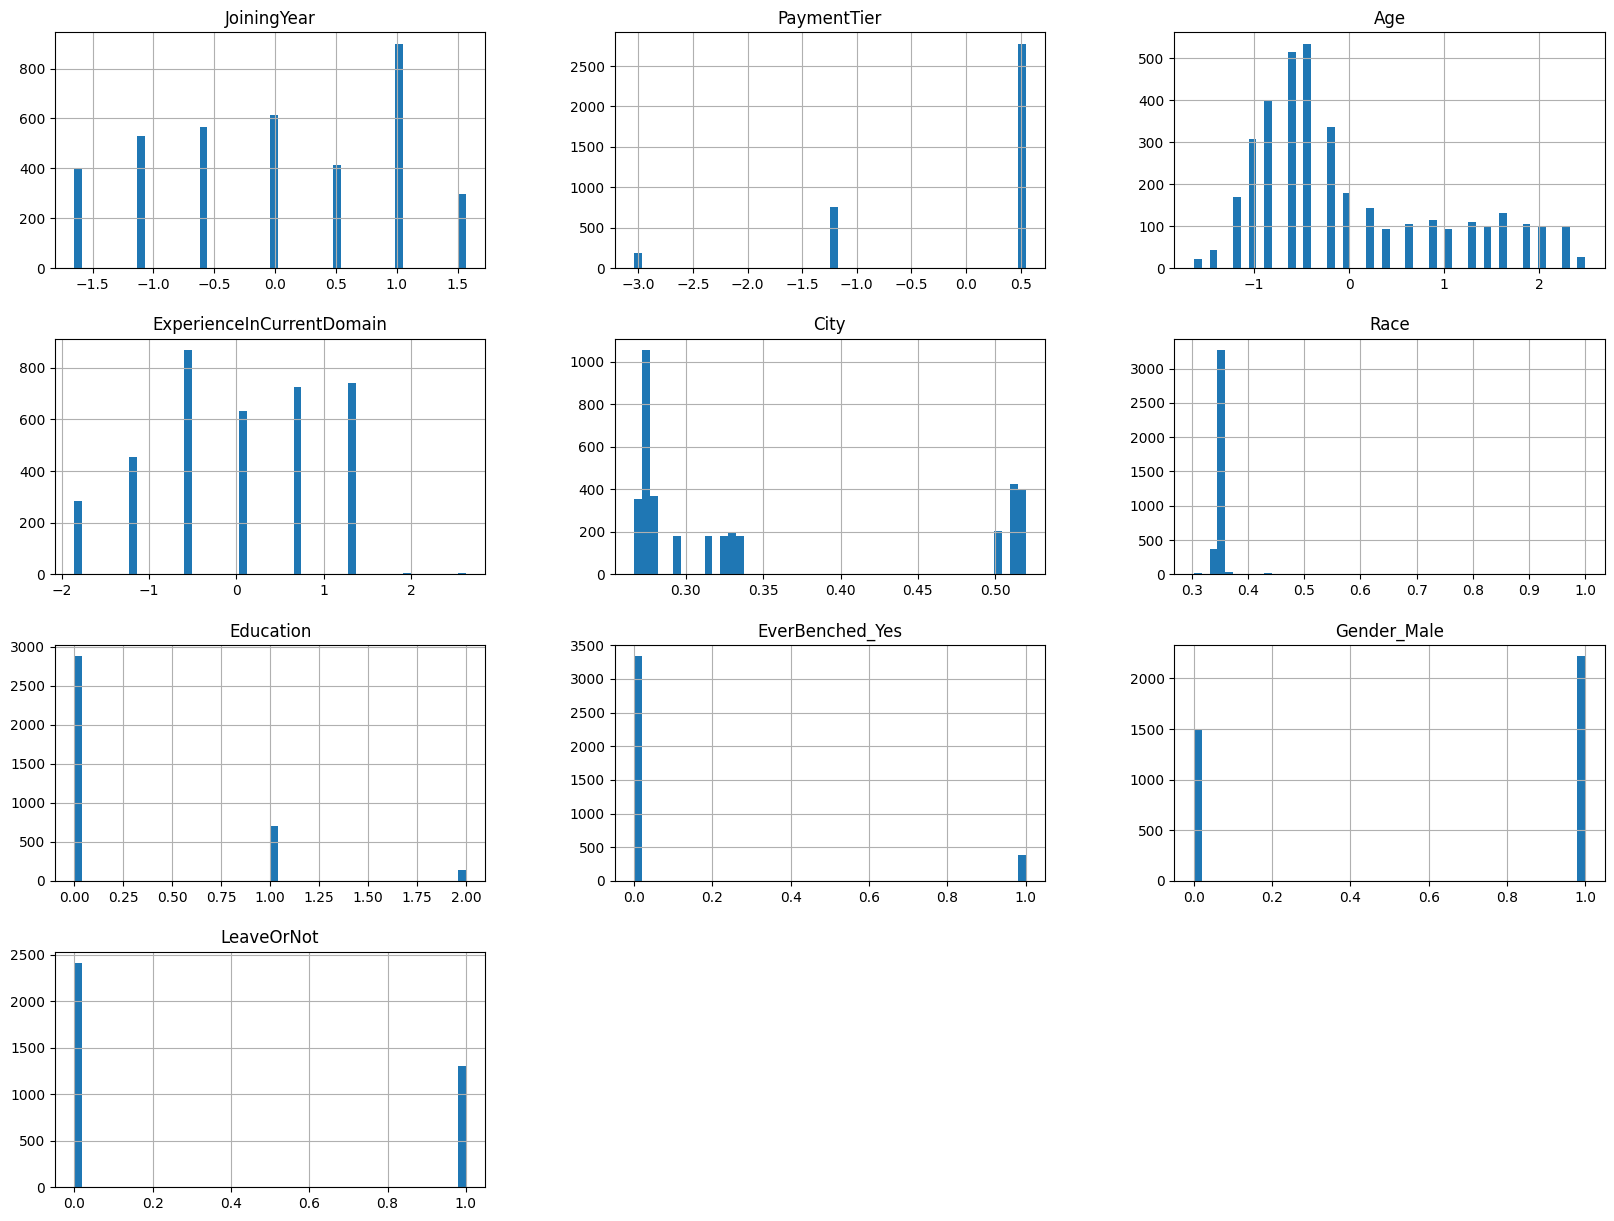

In [9]:
import matplotlib.pyplot as plt

# Plot histograms of all the columns
full_train_ds.hist(bins=50, figsize=(20,15))
plt.show()


In [10]:
# Defining the classifiers and their hyperparameters
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=rnd_state),
        'params': {
            'C': [0.3, 0.5, 1],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear' , 'saga']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=rnd_state),
        'params': {
            'max_depth': [7, 8, 9],
            'min_samples_split': [14, 15, 16]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3]
        }
    },
    'Gaussian Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=rnd_state),
        'params': {
            'n_estimators': [100, 110],
            'max_depth': [15],
            'min_samples_split': [11, 12],
            'min_samples_leaf': [3, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [False]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=rnd_state),
        'params': {
            'n_estimators': [120, 130],
            'learning_rate': [0.03],
            'max_depth': [5],
            'subsample': [0.9],
            'min_samples_split': [3, 4, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=rnd_state),
        'params': {
            'n_estimators': [50],
            'learning_rate': [1.2, 1.3],
            'algorithm' : ['SAMME', 'SAMME.R']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [110, 120],
            'learning_rate': [0.04, 0.05],
            'max_depth': [4, 5, 10],
            'gamma': [0.1],
            'subsample': [0.9, 1.0],
            'colsample_bytree': [0.8, 0.9]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(force_row_wise=True, random_state=rnd_state),
        'params': {
            'n_estimators': [70, 80, 90, 100],
            'learning_rate': [0.1, 0.3, 0.4, 0.5],
            'max_depth': [2, 3, 4, 5, 10, 15]
        }
    }
}


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

# Function to compute metrics for the best model from GridSearchCV
def compute_metrics(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return f1, auc, precision, recall, accuracy


def calculate_metrics(classifiers, X_train, y_train, kfold_cnt: int):
    # To store the best model and its metrics for each classifier
    results = {}

    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3,
                                                        random_state=rnd_state, stratify=y_train)
    kfold = StratifiedKFold(n_splits=kfold_cnt, shuffle=True, random_state=rnd_state)

    # Iterating over each classifier and performing Grid Search
    for classifier_name, classifier_info in classifiers.items():
        # GridSearchCV
        grid_search = GridSearchCV(classifier_info['model'], classifier_info['params'],
                                   cv=kfold, scoring='f1', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        # Compute metrics for the best model
        f1, auc, precision, recall, accuracy = compute_metrics(grid_search.best_estimator_, X_test, y_test)

        # Store results
        results[classifier_name] = {
            'F1 Score': f1,
            'AUC': auc,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'Best Parameters': grid_search.best_params_
        }

    results_df = pd.DataFrame(results).T
    return results_df


In [12]:
%%capture
results = calculate_metrics(classifiers, X_train_prepared, y_train, 5)


In [13]:
# pandas df plot score with best highlighted
to_plot = results[['F1 Score', 'AUC', 'Precision', 'Recall', 'Accuracy']]
to_plot.style.highlight_max(color = 'darkgreen', axis = 0)


,F1 Score,AUC,Precision,Recall,Accuracy
Logistic Regression,0.484277,0.700987,0.631148,0.392857,0.706356
Decision Tree,0.737864,0.838195,0.808511,0.678571,0.830797
KNN,0.642857,0.778937,0.696429,0.596939,0.767234
Gaussian Naive Bayes,0.492582,0.683642,0.588652,0.423469,0.693823
Random Forest,0.746398,0.844507,0.857616,0.660714,0.842435
Gradient Boosting,0.744253,0.849191,0.851974,0.660714,0.840645
AdaBoost,0.647239,0.783455,0.811538,0.538265,0.794091
XGBoost,0.734286,0.845799,0.834416,0.655612,0.833483
LightGBM,0.733146,0.846453,0.815625,0.665816,0.829902


In [14]:
from pprint import pprint
pprint(results['Best Parameters'].to_dict())


{'AdaBoost': {'algorithm': 'SAMME', 'learning_rate': 1.2, 'n_estimators': 50},
 'Decision Tree': {'max_depth': 9, 'min_samples_split': 15},
 'Gaussian Naive Bayes': {},
 'Gradient Boosting': {'learning_rate': 0.03,
                       'max_depth': 5,
                       'min_samples_split': 3,
                       'n_estimators': 130,
                       'subsample': 0.9},
 'KNN': {'n_neighbors': 3},
 'LightGBM': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 90},
 'Logistic Regression': {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'},
 'Random Forest': {'bootstrap': False,
                   'max_depth': 15,
                   'max_features': 'sqrt',
                   'min_samples_leaf': 3,
                   'min_samples_split': 12,
                   'n_estimators': 110},
 'XGBoost': {'colsample_bytree': 0.8,
             'gamma': 0.1,
             'learning_rate': 0.04,
             'max_depth': 5,
             'n_estimators': 120,
             'subsample': 0.9

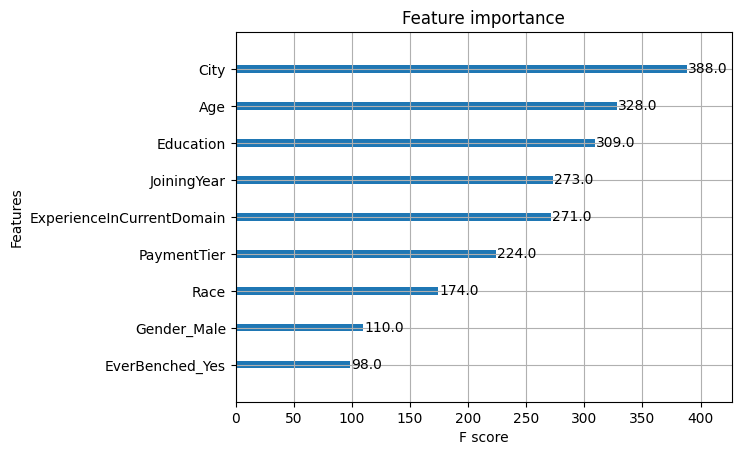

<Figure size 1600x1200 with 0 Axes>

In [15]:
# Importance of features for xgboost
xgb_clf = xgb.XGBClassifier(**results.loc['XGBoost']['Best Parameters'])
xgb_clf.fit(X_train_prepared, y_train)
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()
